In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer, OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_csv('data/SBAnational.csv')

/tmp/ipykernel_11780/833135780.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/SBAnational.csv')


In [3]:
df = df[['Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'GrAppv','MIS_Status']]

In [4]:
df.dropna(inplace=True)

In [5]:
df.isna().sum()

Name             0
City             0
State            0
Zip              0
Bank             0
BankState        0
NAICS            0
ApprovalDate     0
ApprovalFY       0
Term             0
NoEmp            0
NewExist         0
CreateJob        0
RetainedJob      0
FranchiseCode    0
UrbanRural       0
RevLineCr        0
LowDoc           0
GrAppv           0
MIS_Status       0
dtype: int64

In [6]:
df.dtypes

Name              object
City              object
State             object
Zip                int64
Bank              object
BankState         object
NAICS              int64
ApprovalDate      object
ApprovalFY        object
Term               int64
NoEmp              int64
NewExist         float64
CreateJob          int64
RetainedJob        int64
FranchiseCode      int64
UrbanRural         int64
RevLineCr         object
LowDoc            object
GrAppv            object
MIS_Status        object
dtype: object

In [7]:

df['NAICS'] = df['NAICS'].apply(lambda x: int(str(x)[:2])).astype(object)
df['ApprovalFY'] = df['ApprovalFY'].astype(str).str[0:4].astype(int)
df['Term'] = df['Term'].astype(int)
df['NoEmp'] = df['NoEmp'].astype(int)
df['CreateJob'] = df['CreateJob'].astype(int)
df['RetainedJob'] = df['RetainedJob'] .astype(int)
df['FranchiseCode'] = df['FranchiseCode'].astype('category')
df['UrbanRural'] = df['UrbanRural'].astype('category')

df['BankState'] = df['BankState'].astype('category')
df['State'] = df['State'] .astype('category')
df['Zip']= df['Zip'].astype('category')
#df['MIS_Status'] = df['MIS_Status'].astype('category')


display(df.head(2))

print(df.info())


,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,GrAppv,MIS_Status
0,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,45,28-Feb-97,1997,84,4,2.0,0,0,1,0,N,Y,"$60,000.00",P I F
1,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,72,28-Feb-97,1997,60,2,2.0,0,0,1,0,N,Y,"$40,000.00",P I F


<class 'pandas.core.frame.DataFrame'>
Index: 888379 entries, 0 to 899163
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   Name           888379 non-null  object  
 1   City           888379 non-null  object  
 2   State          888379 non-null  category
 3   Zip            888379 non-null  category
 4   Bank           888379 non-null  object  
 5   BankState      888379 non-null  category
 6   NAICS          888379 non-null  object  
 7   ApprovalDate   888379 non-null  object  
 8   ApprovalFY     888379 non-null  int64   
 9   Term           888379 non-null  int64   
 10  NoEmp          888379 non-null  int64   
 11  NewExist       888379 non-null  float64 
 12  CreateJob      888379 non-null  int64   
 13  RetainedJob    888379 non-null  int64   
 14  FranchiseCode  888379 non-null  category
 15  UrbanRural     888379 non-null  category
 16  RevLineCr      888379 non-null  object  
 17  LowDoc         

In [8]:
# Supprimer le signe dollar 
df['GrAppv'] = df['GrAppv'].apply(lambda x: x.replace('$', ''))

# supprimer la virgule
df['GrAppv'] = df['GrAppv'].apply(lambda x: x.replace(',', ''))

# supprimer le point
df['GrAppv'] = df['GrAppv'].apply(lambda x: x.replace('.', ''))

# Convertir en int
df['GrAppv'] = df['GrAppv'].astype(int)    

In [9]:
# Secteurs du NAICS
secteurs = {
    11 : 'Agriculture, forest, fishing',
    21 : 'Mining, oil, Gaz',
    22 : 'Utilities',
    23 : 'Construction',
    31 : 'Manufacturing',
    32 : 'Manufacturing',
    33 : 'Manufacturing',
    42 : 'Wolesale trade',
    44 : 'Retail trade',
    45 : 'Retail trade',
    48 : 'Transportation and warehousing',
    49 : 'Transportation and warehousing',
    51 : 'Information',
    52 : 'Finance and insurance',
    53 : 'Real estate and rental, leasing',
    54 : 'Professional, scientific, technical services',
    55 : 'Management of companies and entreprises',
    56 : 'Administrative and support',
    61 : 'Educational services',
    62 : 'Health care and social',
    71 : 'Arts, entertainment',
    81 : 'Other services',
    92 : 'Public administration'
}

In [10]:
# Colonne qui indique les secteurs du NAICS
df['Sectors'] = df['NAICS'].map(secteurs)

In [11]:
df['Sectors']
# Suppression des valeurs NaN à la fin
df.dropna(subset=['Sectors'], inplace=True)

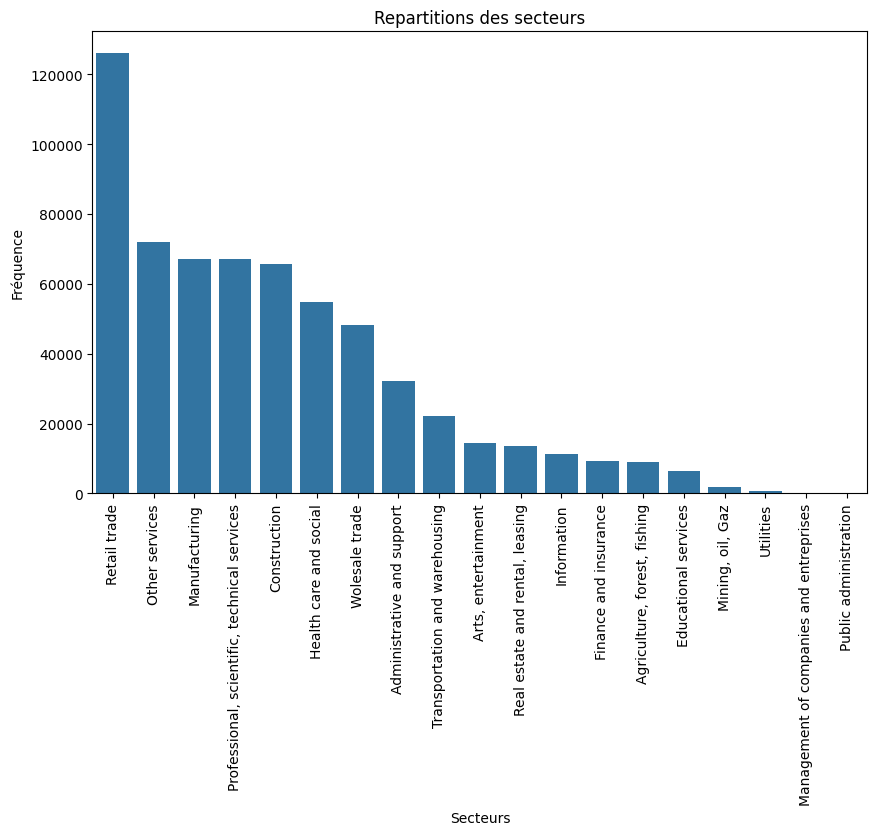

In [12]:
sector_counts = df['Sectors'].value_counts()

# Création du diagramme en barres
plt.figure(figsize=(10, 6))
sns.barplot(x=sector_counts.index, y=sector_counts.values)
plt.title('Repartitions des secteurs')
plt.xlabel('Secteurs')
plt.xticks(rotation = 90)
plt.ylabel('Fréquence')
plt.show()

In [13]:
from feature_engine.imputation import CategoricalImputer
from sklearn.preprocessing import LabelBinarizer

imputer = CategoricalImputer(imputation_method='frequent', variables=['MIS_Status'])
df = imputer.fit_transform(df)

df.MIS_Status = LabelBinarizer().fit_transform(df.loc[:,['MIS_Status']])
df.MIS_Status = df.MIS_Status.astype('category')

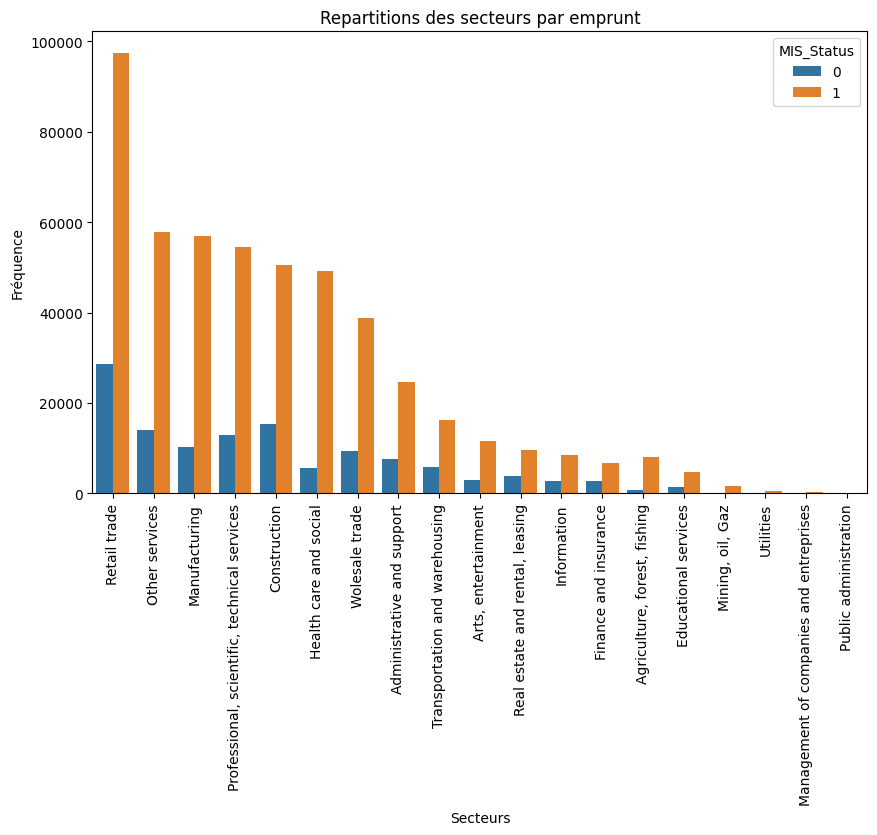

In [14]:
sector_counts = df['Sectors'].value_counts()
order = sector_counts.index

# Création du diagramme en barres
plt.figure(figsize=(10, 6))
sns.countplot(x='Sectors', hue='MIS_Status', data=df, order=order)
plt.title('Repartitions des secteurs par emprunt')
plt.xlabel('Secteurs')
plt.xticks(rotation = 90)
plt.ylabel('Fréquence')
plt.show()

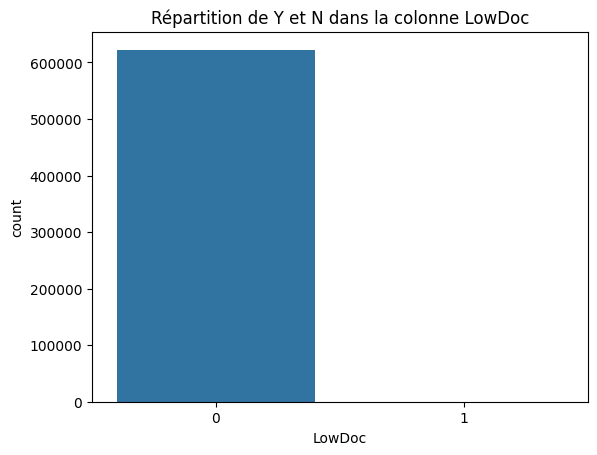

LowDoc
0    622577
1        55
Name: count, dtype: int64

In [15]:
import numpy as np

# Remplacement des valeurs '[C,S,A,R,1,0]' par NaN
df.loc[df['LowDoc'].isin(['C','S','A','R','1','0']), 'LowDoc'] = np.nan

# Remplacement de 'N' par 0 et 'Y' par 1
df.loc[df['LowDoc'] == 'N', 'LowDoc'] = 0
df.loc[df['LowDoc'] == 'Y', 'LowDoc'] = 1

# Remplacement des valeurs différentes de 0 et 1 par NaN
df.loc[~df['LowDoc'].isin([0,1]), 'LowDoc'] = np.nan

# Conversion de la colonne 'GrAppv' en type numérique si ce n'est pas déjà le cas
df['GrAppv'] = pd.to_numeric(df['GrAppv'], errors='coerce')

# Remplacement des valeurs en fonction de la condition
df.loc[df['GrAppv'] >= 150000, 'LowDoc'] = 0
df.loc[df['GrAppv'] < 150000, 'LowDoc'] = 1

# Suppression des valeurs NaN à la fin
df.dropna(subset=['LowDoc'], inplace=True)



# Utilise la fonction countplot de Seaborn
sns.countplot(x=df['LowDoc'], data=df)

plt.title('Répartition de Y et N dans la colonne LowDoc')
plt.show()
df['LowDoc'].value_counts()

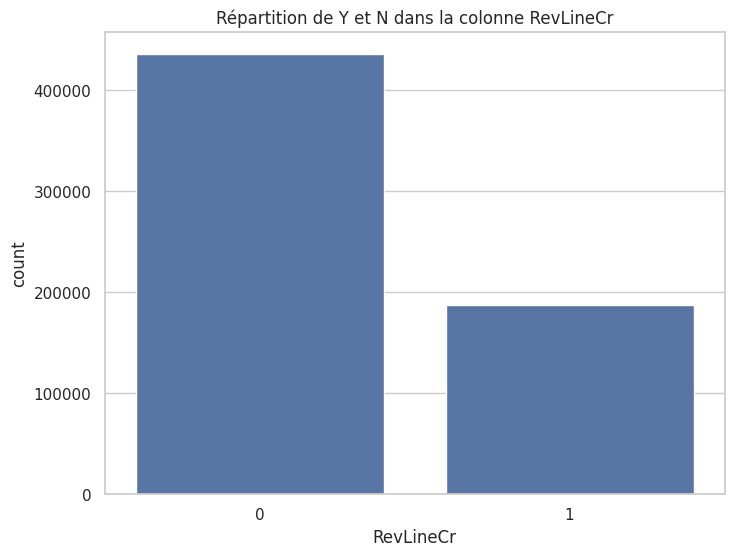

[0 1]


In [16]:
from feature_engine.imputation import RandomSampleImputer
#Corrige la colonne RevLineCr
# Remplacement des valeurs 'N' par 0 et 'Y' par 1
df['RevLineCr'] = df['RevLineCr'].replace({'N': 0, 'Y': 1})

# Remplacement des chaînes '0' par 0 et '1' par 1
df['RevLineCr'] = df['RevLineCr'].replace({'0': 0, '1': 1})

#  Remplacement des valeurs différentes de 0 et 1 par NaN
df['RevLineCr'] = np.where((df['RevLineCr'] != 0) & (df['RevLineCr'] != 1), np.nan, df['RevLineCr'])

imputer = RandomSampleImputer()

result = imputer.fit_transform(df.loc[:,['RevLineCr']])
df.RevLineCr = result['RevLineCr']
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Utilise la fonction countplot de Seaborn
sns.countplot(x='RevLineCr', data=df)

plt.title('Répartition de Y et N dans la colonne RevLineCr')
plt.show()
print(df['RevLineCr'].unique())

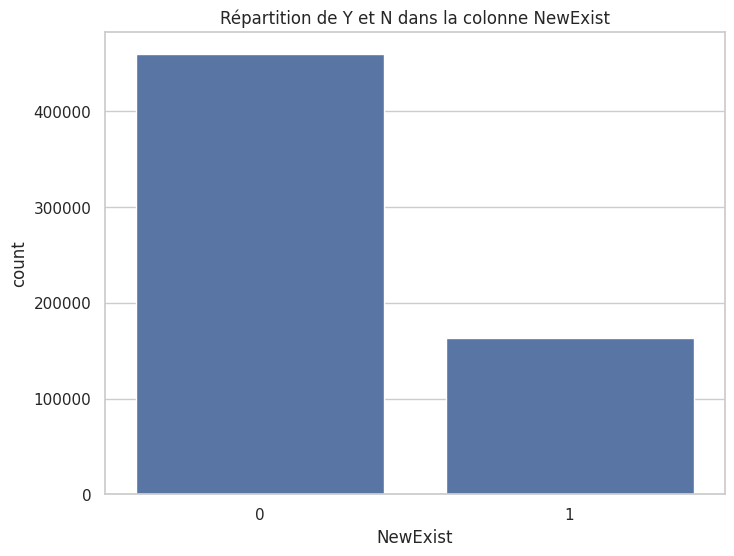

In [17]:
selected_column = df['NewExist']
replaced_values = selected_column.replace({1.0: 0, 2.0: 1, 0: np.nan})
filled_values = replaced_values.fillna(0)
final_result = filled_values.astype(int)
df['NewExist'] = final_result

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Utilise la fonction countplot de Seaborn
sns.countplot(x='NewExist', data=df)

plt.title('Répartition de Y et N dans la colonne NewExist')
plt.show()

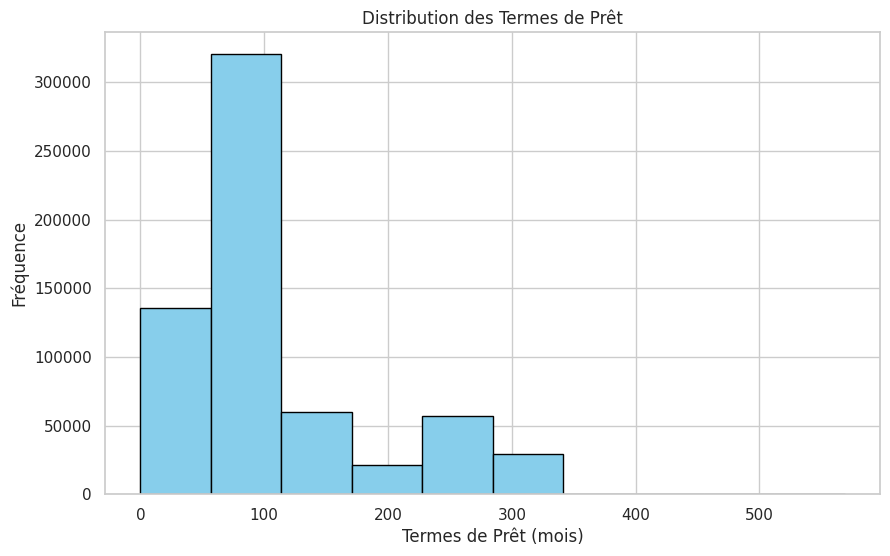

In [18]:
df['Term'] = pd.to_numeric(df['Term'], errors='coerce')

# Créer un histogramme
plt.figure(figsize=(10, 6))
plt.hist(df['Term'].dropna(), bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution des Termes de Prêt')
plt.xlabel('Termes de Prêt (mois)')
plt.ylabel('Fréquence')
plt.show()

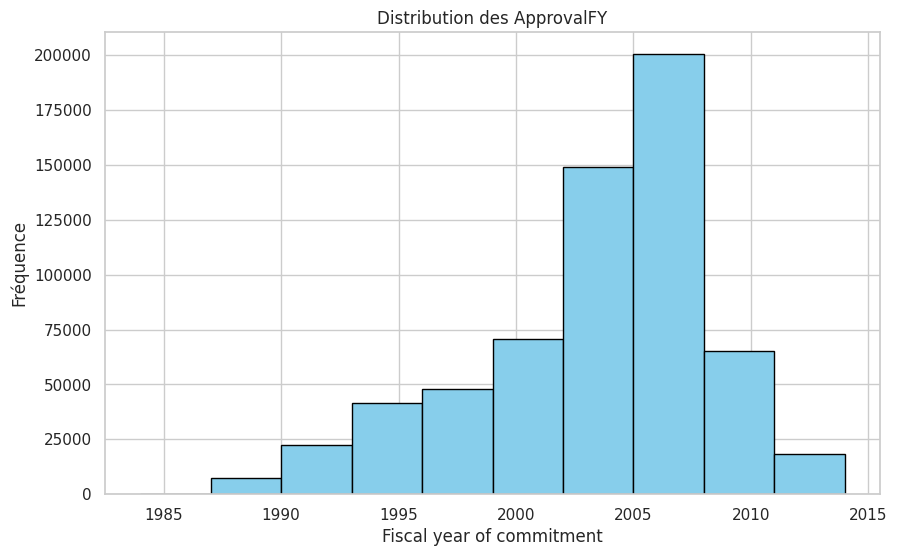

In [19]:
# Créer un histogramme
plt.figure(figsize=(10, 6))
plt.hist(df['ApprovalFY'].dropna(), color='skyblue', edgecolor='black')
plt.title('Distribution des ApprovalFY')
plt.xlabel('Fiscal year of commitment')
plt.ylabel('Fréquence')
plt.show()

In [21]:
df['GrAppv']

0          6000000
2         28700000
5         51700000
7          4500000
10         7000000
            ...   
899156     5000000
899157    20000000
899159     7000000
899160     8500000
899161    30000000
Name: GrAppv, Length: 622632, dtype: int64

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f32a398d090>>
Traceback (most recent call last):
  File "/home/antoine/projets/US-SBA/venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


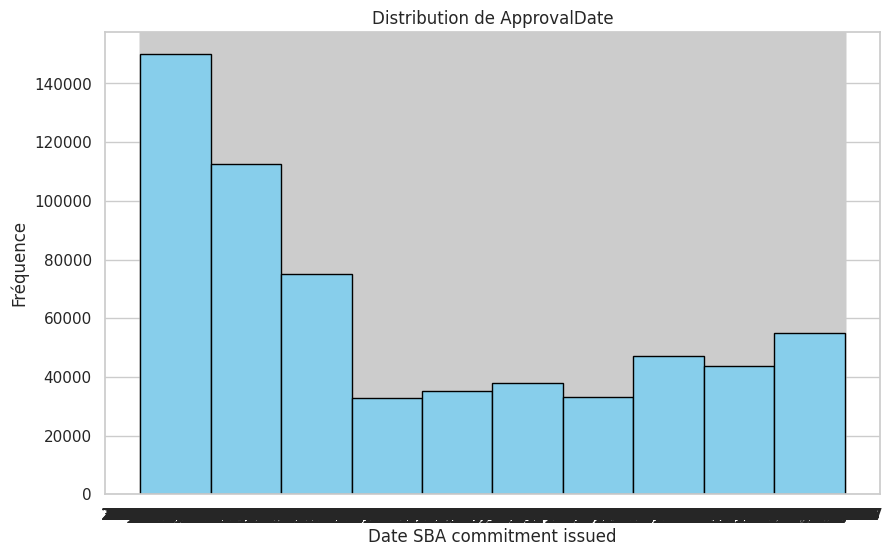

In [20]:
# Créer un histogramme
plt.figure(figsize=(10, 6))
plt.hist(df['ApprovalDate'].dropna(), bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution de ApprovalDate')
plt.xlabel('Date SBA commitment issued')
plt.ylabel('Fréquence')
plt.show()

In [ ]:
import pickle

# Sauvegarder les données traitées avec pickle
with open('donnees_traitees.pkl', 'wb') as f:
    pickle.dump(df, f)
